# Evaluate

This notebook evaluates the network trained by previous notebooks and analyzes the results.

-----

## Load Packages

In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%cd ..
%load_ext autoreload
%autoreload 2

C:\Users\Minjae\Documents\GitHub\caueeg-ceednet


In [2]:
# Load some packages
import os
from copy import deepcopy
import hydra
from omegaconf import OmegaConf
from collections import OrderedDict

import numpy as np
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pprint
import matplotlib
import matplotlib.pyplot as plt

# custom package
from datasets.caueeg_script import build_dataset_for_train
import models
from train.evaluate import check_accuracy
from train.evaluate import check_accuracy_extended
from train.evaluate import check_accuracy_multicrop
from train.evaluate import check_accuracy_multicrop_extended
from train.visualize import draw_roc_curve
from train.visualize import draw_confusion
from train.visualize import draw_class_wise_metrics
from train.visualize import annotate_heatmap

In [3]:
print('PyTorch version:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available(): print('cuda is available.')
else: print('cuda is unavailable.') 

PyTorch version: 1.12.1
cuda is available.


-----

## Load the configuration used during the train phase

In [4]:
model_name = '2s1700lg'
model_path = os.path.join(r'local\checkpoint', model_name, 'checkpoint.pt')

ckpt = torch.load(model_path, map_location=device)
print(ckpt.keys())

dict_keys(['model_state', 'config', 'optimizer_state', 'scheduler_state'])


In [5]:
model_state = ckpt['model_state']
config = ckpt['config']
optimizer = ckpt['optimizer_state']
scheduler = ckpt['scheduler_state']

-----

## Load the target model

In [6]:
model = hydra.utils.instantiate(config).to(device)

if config.get('ddp', False):
    model_state_ddp = deepcopy(model_state)
    model_state = OrderedDict()
    for k, v in model_state_ddp.items():
        name = k[7:] # remove 'module.' of DataParallel/DistributedDataParallel
        model_state[name] = v
        
model.load_state_dict(model_state)

<All keys matched successfully>

-----

## Evaluate the model and analyze the performance by the crop timing

### Configurations

In [7]:
config = ckpt['config']

config.pop('cwd', 0)
config['dataset_path'] = r'local/dataset/caueeg-dataset'
config['file_format'] = 'feather'
config['ddp'] = False
config['crop_timing_analysis'] = True
config['eval'] = True
config['device'] = device

repeat = round(500 / config['crop_multiple'])  # 500
print(repeat)

125


### Build Dataset

In [8]:
train_loader, val_loader, test_loader, multicrop_test_loader = build_dataset_for_train(config, verbose=False)

### Train set

In [9]:
_ = check_accuracy_extended(model, train_loader, 
                            config['preprocess_test'], config, repeat=repeat)
train_acc = _[0] 
train_score = _[1]
train_target = _[2]
train_confusion = _[3]

print(train_acc)

99.94196428571429


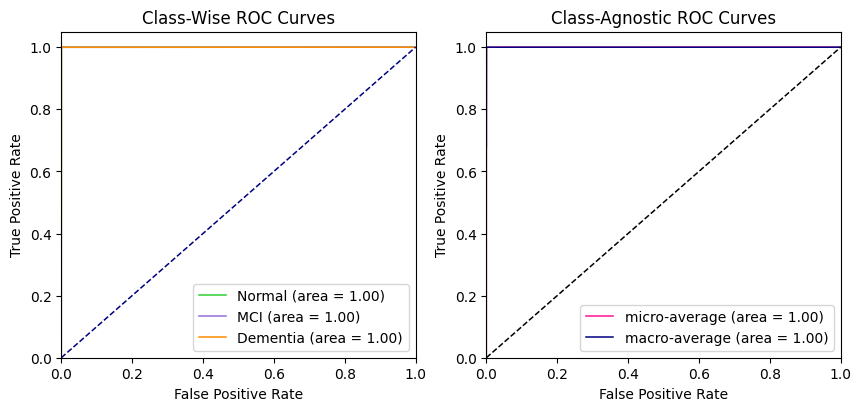

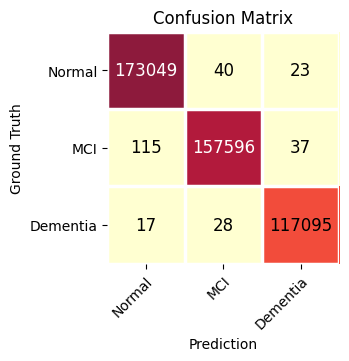

In [10]:
draw_roc_curve(train_score, train_target, config['class_label_to_name'], use_wandb=False)
draw_confusion(train_confusion, config['class_label_to_name'], use_wandb=False)

### Validation set

In [11]:
_ = check_accuracy_extended(model, val_loader, 
                            config['preprocess_test'], config, repeat=repeat)
val_acc = _[0]
val_score = _[1]
val_target = _[2]
val_confusion = _[3]

print(val_acc)

61.72436974789915


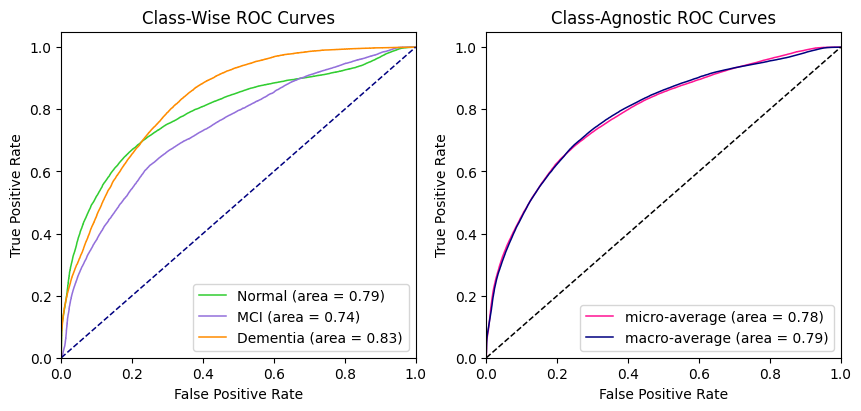

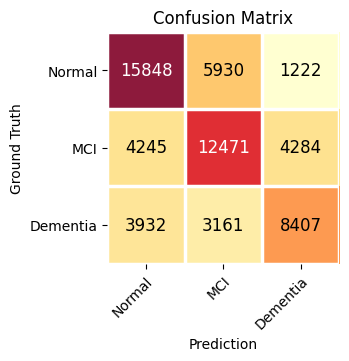

In [12]:
draw_roc_curve(val_score, val_target, config['class_label_to_name'], use_wandb=False)
draw_confusion(val_confusion, config['class_label_to_name'], use_wandb=False)

### Test set

In [13]:
_ = check_accuracy_extended(model, test_loader, 
                            config['preprocess_test'], config, repeat=repeat)
test_acc = _[0]
test_score = _[1]
test_target = _[2]
test_confusion = _[3]

print(test_acc)

65.96610169491525


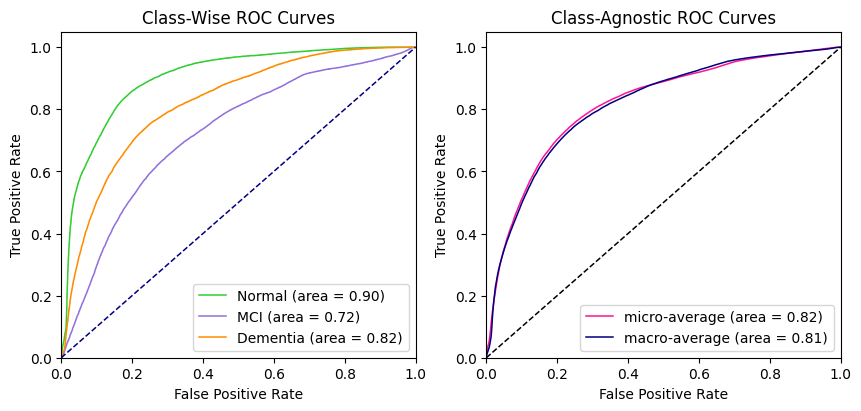

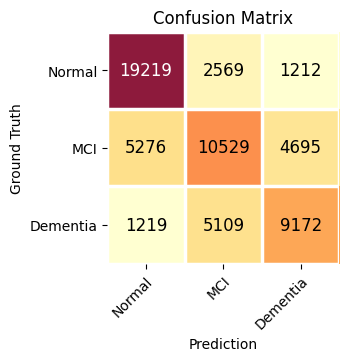

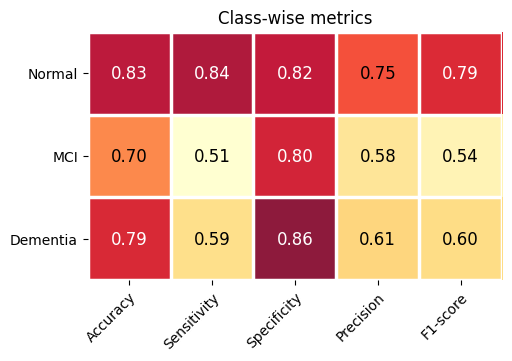

In [14]:
draw_roc_curve(test_score, test_target, config['class_label_to_name'], use_wandb=False)
draw_confusion(test_confusion, config['class_label_to_name'], use_wandb=False)
draw_class_wise_metrics(test_confusion, config['class_label_to_name'], use_wandb=False)

### Test set (with test-time augmentation)

In [15]:
_ = check_accuracy_multicrop_extended(model, multicrop_test_loader, 
                                      config['preprocess_test'], config, repeat=repeat)
multi_test_acc = _[0]
multi_test_score = _[1]
multi_test_target = _[2]
multi_test_confusion = _[3]

print(multi_test_acc)

68.7728813559322


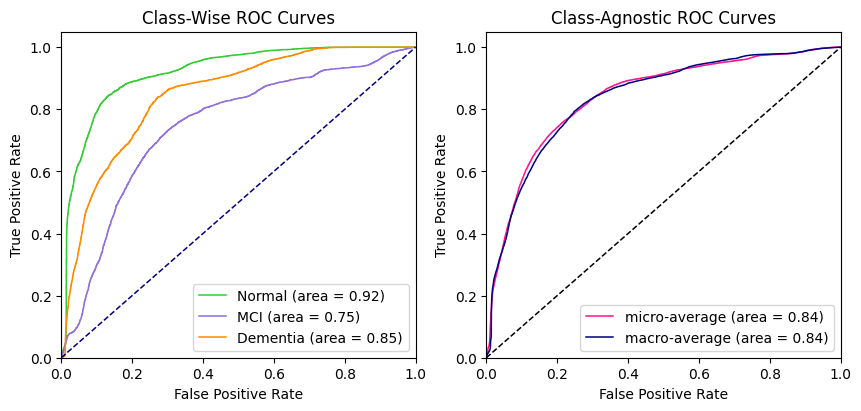

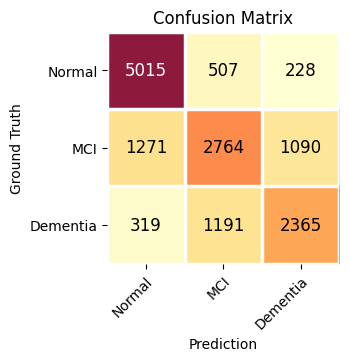

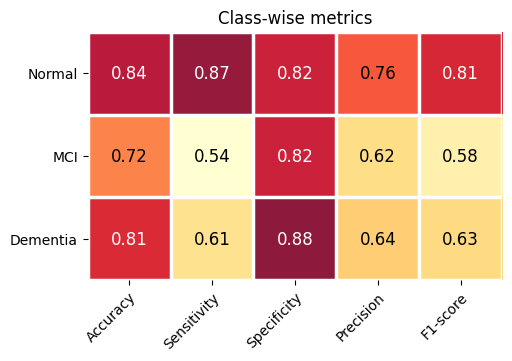

In [16]:
draw_roc_curve(multi_test_score, multi_test_target, config['class_label_to_name'], use_wandb=False)
draw_confusion(multi_test_confusion, config['class_label_to_name'], use_wandb=False)
draw_class_wise_metrics(multi_test_confusion, config['class_label_to_name'], use_wandb=False)